# AM 207 project code
### Walter Shen
(Fall 2024) Project code for final project for APMTH 207: Advanced Scientific Computing: Stochastic Methods for Data Analysis, Inference and Optimization

# Table of contents
1. [Introduction](#introduction)
2. [Some paragraph](#paragraph1)
    1. [Sub paragraph](#subparagraph1)
3. [Another paragraph](#paragraph2)

### Import Libraries

In [20]:
## import libraries

import sys
import os
import csv

import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

import datetime
from IPython.display import display

# xarray
import xarray as xr
import dask

import yaml

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# progres bar
from tqdm.auto import tqdm
tqdm.pandas()

### Functions
For calculation of thermodynamic variables

In [2]:
def es(t):
    # saturation pressure, Pa
    # input K
    return 611.2*np.exp(17.67*(t-273)/(t-29.5))

def Td(p, r):
    # returned by matlabFunction(finverse(es(x)))
    x = r/18*29*p*100
    return (np.log(x*1.636125654450262e-3)*(5.9e+1/2.0)-4.82391e+3)/(np.log(x*1.636125654450262e-3)-1.767e+1)
    

def equi_pot(T, p, r):
    # Calculate equivalent potential temperature, following Wikipedia (and Bolton, 1980)
    # inputs: temperature, pressure (hPa), vapor mixing ratio (kg/kg)
    T_L=1/(1/(T-56)+np.log(T/Td(p, r))/800)+56
    theta_L=T*(1000/p)**(287/1004)*(T/T_L)**(0.28*r);
    return theta_L*np.exp((3036/T_L-1.78)*r*(1+0.448*r))

def w_s(t, p):
    # water vapor saturation mixing ratio, kg/kg
    return es(t)/100/p*(18/29)

#### Seed
For reproducability

In [3]:
seed = 42
np.random.seed(seed)

# 1. Monte Carlo Sampling from LES

### Import BOMEX (virtual) .nc files
Import .nc files as merged along time.

In [4]:
# directory with BOMEX nc files
nc_dir = '/n/netscratch/kuang_lab/Everyone/4Walter/BOMEXlargeDomain/'

# Open multiple NetCDF files as a single xarray dataset
ds = xr.open_mfdataset(nc_dir+'BOMEX_lrg_512_*.nc', combine='by_coords', parallel=True, chunks={'time': 10})

print(ds)

<xarray.Dataset> Size: 8TB
Dimensions:  (time: 900, z: 80, y: 2048, x: 2048)
Coordinates:
  * x        (x) float32 8kB 0.0 100.0 200.0 ... 2.045e+05 2.046e+05 2.047e+05
  * y        (y) float32 8kB 0.0 100.0 200.0 ... 2.045e+05 2.046e+05 2.047e+05
  * z        (z) float32 320B 10.0 60.0 110.0 ... 3.86e+03 3.91e+03 3.96e+03
  * time     (time) float32 4kB 180.0 180.0 180.0 180.0 ... 181.9 181.9 181.9
Data variables:
    p        (time, z) float32 288kB dask.array<chunksize=(1, 80), meta=np.ndarray>
    U        (time, z, y, x) float32 1TB dask.array<chunksize=(1, 80, 2048, 2048), meta=np.ndarray>
    V        (time, z, y, x) float32 1TB dask.array<chunksize=(1, 80, 2048, 2048), meta=np.ndarray>
    W        (time, z, y, x) float32 1TB dask.array<chunksize=(1, 80, 2048, 2048), meta=np.ndarray>
    PP       (time, z, y, x) float32 1TB dask.array<chunksize=(1, 80, 2048, 2048), meta=np.ndarray>
    TABS     (time, z, y, x) float32 1TB dask.array<chunksize=(1, 80, 2048, 2048), meta=np.ndarra

### Function to conduct 1 virtual flight rectangle, given start vector/time

In [10]:
def generate_virtual_flight(ds, var_name='TABS'):
    # returns corners of rectangles; as well as virtual trajectory location/time/variable "dumps"
    
    # generate valid path (within domain)
    while(True):
        # R-pattern start, shape
        x_start = np.random.uniform(0, 200000)
        y_start = np.random.uniform(0, 200000)
        t_start = np.random.choice(np.arange(30000 + (60 - 30000 % 60), 50001, 60))
        z_start = 810 #1210
        gamma = np.random.uniform(0, np.pi)

        # R-pattern start, end points
        x_0, y_0 = x_start, y_start
        x_1, y_1 = x_0 + R_y * np.sin(gamma), y_0 + R_y * np.cos(gamma)
        x_2, y_2 = x_1 + R_x * np.cos(gamma), y_1 - R_x * np.sin(gamma)
        x_3, y_3 = x_0 + R_x * np.cos(gamma), y_0 - R_x * np.sin(gamma)

        x_corners = np.array([x_0, x_1, x_2, x_3, x_0])
        y_corners = np.array([y_0, y_1, y_2, y_3, y_0])
        x_corners_rounded = np.round(x_corners / 100) * 100
        y_corners_rounded = np.round(y_corners / 100) * 100
        
        if np.all((x_corners_rounded >= 0) & (x_corners_rounded <= 200000)) and np.all((y_corners_rounded >= 0) & (y_corners_rounded <= 200000)):
            break
        
    # LES gridpoint times
    LES_timestep = 60 # 60 second dump
    LES_time_stamps = np.arange(60, 54000+1, LES_timestep)

    # virtual trajectory
    x_vtraj = np.concatenate((np.linspace(x_0, x_1, 21), np.linspace(x_1, x_2, 4), 
                              np.linspace(x_2, x_3, 21), np.linspace(x_3, x_0, 4)))
    y_vtraj = np.concatenate((np.linspace(y_0, y_1, 21), np.linspace(y_1, y_2, 4), 
                              np.linspace(y_2, y_3, 21), np.linspace(y_3, y_0, 4)))
    t_vtraj = np.arange(t_start, t_start+y_vtraj.size*60, 60)
    t_vtraj_ind = np.where(np.isin(LES_time_stamps, t_vtraj))[0]
    
    var_vtraj = np.zeros(t_vtraj.size)
    for t_i in range(0,t_vtraj.size):
        var_vtraj[t_i] = ds[var_name].sel(x=x_vtraj[t_i], y=y_vtraj[t_i], z=z_start, time=ds['time'][t_vtraj_ind[t_i]], method='nearest')
        
    return x_corners, y_corners, x_vtraj, y_vtraj, t_vtraj, var_vtraj

### Bias of Monte Carlo Estimator

In [50]:
# generate N random samples

N = 100
var_name='QV'
x_corners_samples = []
y_corners_samples = []
var_vtraj_samples = []

R_x = 18000
R_y = 120000
aircraft_speed = 100 # 100 m/s

# LES gridpoint times
LES_timestep = 60 # 60 second dump
LES_time_stamps = np.arange(60, 54000+1, LES_timestep)

In [51]:
# (re)set seed
np.random.seed(seed)

for sample in range(N):
    if sample == 0:
        x_corners, y_corners, _, _, _, var_vtraj = generate_virtual_flight(ds, var_name)
        x_corners_samples = x_corners
        y_corners_samples = y_corners
        var_vtraj_samples = var_vtraj
        continue
    x_corners, y_corners, _, _, _, var_vtraj = generate_virtual_flight(ds, var_name)
    x_corners_samples = np.vstack((x_corners_samples, x_corners))
    y_corners_samples = np.vstack((y_corners_samples, y_corners))
    var_vtraj_samples = np.vstack((var_vtraj_samples, var_vtraj))

In [52]:
# mean; distribution water vapor at midpoint time

domain_time = 40020
domain_time_ind = np.where(np.isin(LES_time_stamps, domain_time))[0][0]
var_domain = ds['QV'].sel(z=810, time = ds['time'][domain_time_ind])

n, bins, _ = plt.hist(var_domain.values.flatten(), density=True, bins = 100)
bin_centers = 0.5*(bins[1:]+bins[:-1])
plt.clf()

M = var_vtraj_samples.flatten().size

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_2113325/577402609.py:26: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f'generated_images/Fig_2_simulated_flight_pattern.png')


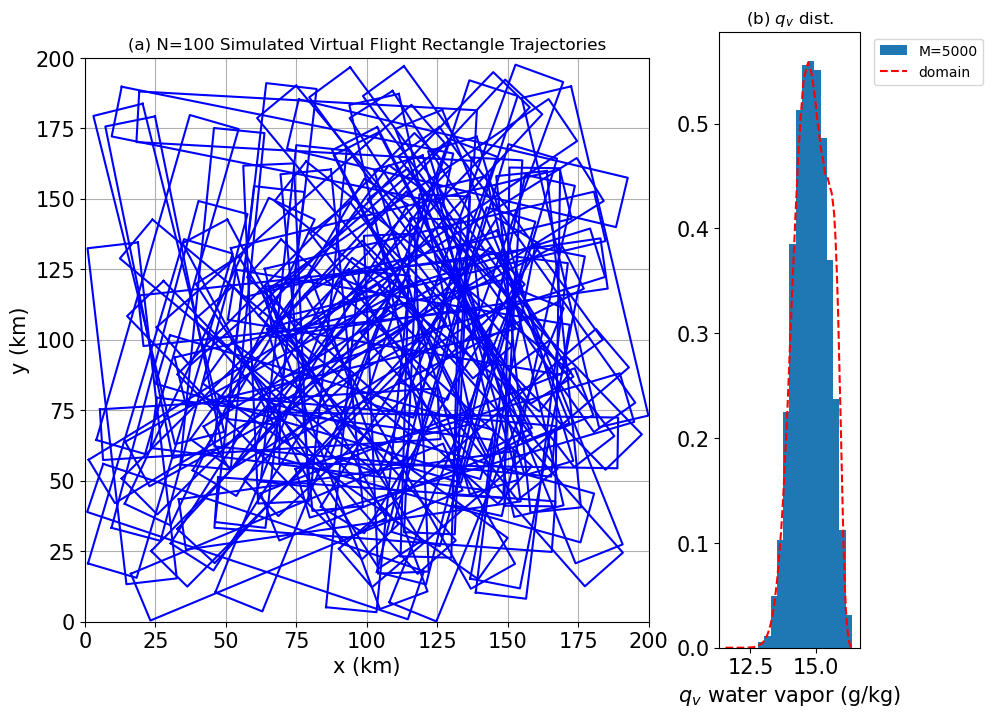

In [92]:
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])  

ax1 = fig.add_subplot(gs[0])
for i in range(N):
    ax1.plot(x_corners_samples[i]/1000,y_corners_samples[i]/1000, c='b')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)
ax1.grid()
ax1.set_title(f'(a) N={N} Simulated Virtual Flight Rectangle Trajectories', fontsize='12')

#plt.savefig(f'generated_images/virtual_flight_map_poster.png')
ax2 = fig.add_subplot(gs[1])
ax2.hist(var_vtraj_samples.flatten(), density=True, bins = 15, label=f'M={M}')
ax2.plot(bin_centers, n, 'r--', label = 'domain')
ax2.set_title(f'(b) $q_v$ dist.', fontsize='12')
ax2.legend(fontsize='10', loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.set_xlabel(f'$q_v$ water vapor (g/kg)')

# plt.tight_layout()
# plt.show()

plt.savefig(f'generated_images/Fig_2_simulated_flight_pattern.png')

### calculate distributions of samples; error

In [54]:
## errors
f_rand_vars = var_vtraj_samples.flatten()
M = f_rand_vars.size

f_M_mean = np.mean(f_rand_vars)

f_M_var = (M/(M-1)) * ((1/M)*sum(f**2 for f in f_rand_vars) - f_M_mean**2)

error_M = np.sqrt(f_M_var/M)

In [55]:
print('mean of domain', np.mean(var_domain.values.flatten()))
print('mean of virtual rectangles', f_M_mean)

mean of domain 14.860894
mean of virtual rectangles 14.807274927711488


In [56]:
print('number of rectangles', N)
print('number of sample points M', M)
print('f_M_mean', f_M_mean)
print('error', error_M)
print('order of error', M**(-0.5))

number of rectangles 100
number of sample points M 5000
f_M_mean 14.807274927711488
error 0.008752226630555355
order of error 0.01414213562373095


# 2. Implement a Rejection Sampling

In [57]:
aircraft_name = 'ATR'
flight_number = 16

# EUREC4A tracks

ds_ATR_tracks = xr.open_dataset('../../2024_Spring/EUREC4A_generate_Paluch/EUREC4A_flight_data/tracks/EUREC4A_tracks_ATR_v1.0.nc')
# display(ds_ATR_tracks)

In [58]:
## Import files for all flights
flight_data_dir = '../../2024_Spring/EUREC4A_generate_Paluch/EUREC4A_flight_data/ATR/'
flight_data_LWC_dir = '../../2024_Spring/EUREC4A_generate_Paluch/EUREC4A_flight_data/ATR/PMA/'
flight_data_segments_dir = '../../2024_Spring/EUREC4A_generate_Paluch/EUREC4A_flight_data/ATR/segments/'

if flight_number == 2:
    # ncfile with key variables
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200125_as200002_L2_V2.nc')
    # ncfile with lwc statistics
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200125_F02_v1.nc')
    # json file with segment times?
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF02_20200125_allsegments.yaml'
elif flight_number == 3:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200126_as200003_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200126_F03_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF03_20200126_allsegments.yaml'
elif flight_number == 4:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200126_as200004_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200126_F04_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF04_20200126_allsegments.yaml'
elif flight_number == 5:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200128_as200005_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200128_F05_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF05_20200128_allsegments.yaml'
elif flight_number == 6:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200130_as200006_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200130_F06_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF06_20200130_allsegments.yaml'
elif flight_number == 7:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200131_as200007_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200131_F07_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF07_20200131_allsegments.yaml'
elif flight_number == 8:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200131_as200008_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200131_F08_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF08_20200131_allsegments.yaml'
elif flight_number == 9:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200202_as200009_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200202_F09_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF09_20200202_allsegments.yaml'
elif flight_number == 10:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200202_as200010_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200202_F10_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF10_20200202_allsegments.yaml'
elif flight_number == 11:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200205_as200011_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200205_F11_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF11_20200205_allsegments.yaml'
elif flight_number == 12:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200205_as200012_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200205_F12_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF12_20200205_allsegments.yaml'
elif flight_number == 13:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200207_as200013_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200207_F13_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF13_20200207_allsegments.yaml'
elif flight_number == 14:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200207_as200014_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200207_F14_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF14_20200207_allsegments.yaml'
elif flight_number == 15:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200209_as200015_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200209_F15_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF15_20200209_allsegments.yaml'
elif flight_number == 16:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200209_as200016_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200209_F16_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF16_20200209_allsegments.yaml'
elif flight_number == 17:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200211_as200017_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200211_F17_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF17_20200211_allsegments.yaml'
elif flight_number == 18:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200211_as200018_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200211_F18_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF18_20200211_allsegments.yaml'
elif flight_number == 19:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200213_as200019_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200213_F19_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF19_20200213_allsegments.yaml'
elif flight_number == 20:
    ds_ATR = xr.open_dataset(flight_data_dir+'EUREC4A_SAFIRE_ATR_Core_1Hz_20200213_as200020_L2_V2.nc')
    ds_ATR_LWC = xr.open_dataset(flight_data_LWC_dir+'EUREC4A_ATR_PMA_Composite-CDP-2DS_20200213_F20_v1.nc')
    ds_ATR_segments_filename = flight_data_segments_dir + 'ATR_RF20_20200213_allsegments.yaml'


In [59]:
# Floor the ATR time, replace time coord
ds_ATR.coords['time'] = pd.to_datetime(ds_ATR.time).floor('s')

# convert LWC to datetime, replace time coord
ds_ATR_LWC.coords['time'] = pd.to_datetime(ds_ATR_LWC.time, unit='s', origin=pd.Timestamp('2020-01-01'))

# merge along time, picking vars from LWC to override main file when applicable
ds_ATR_merged = xr.merge([ds_ATR_LWC, ds_ATR], compat = 'override')

In [60]:
T_a = ds_ATR_merged['TEMPERATURE'] + 273.15 # Static Air Temperature, K

x = ds_ATR_merged['LONGITUDE'] #Latitude E
y = ds_ATR_merged['LATITUDE'] #Latitude N
z = ds_ATR_merged['ALTITUDE'] #altitude m
time = ds_ATR_merged['time'] # time

pres = ds_ATR_merged['PRESSURE'] #pressure hPa
w = ds_ATR_merged['VERTICAL_WIND'] # vert wind comp. m/s

q_v = ds_ATR_merged['MR1']/1000 # water vapor mixing ratio kg/kg

# calculate q_l from LWC
T_d = ds_ATR_merged['DEW_POINT1'] + 273.15 # Dew point temp, K
rh = es(T_d) / es(T_a) * (pres*100 -es(T_a)) / (pres*100 -es(T_d)) # do all operations with pressure in Pa
pres_v = (rh*es(T_a)) # partial pressure vapor, Pa
pres_d = (pres*100 - pres_v) # partial pressure dry air, Pa
R_d = 287.058 # specific gas constant for dry air, J/(kg·K)
R_v = 461.495 # specific gas constant for water vapor, J/(kg·K)
rho_air = pres_d/(R_d*T_a) + pres_v/(R_v*T_a) # density of moist air kg/m3, from Wikipedia
LWC = ds_ATR_merged['LWC']/1000 # liquid water content, kg/m3
q_l = LWC / rho_air # liquid water mixing ratio, kg/kg

q_t = q_v + q_l

In [61]:
# Read the YAML segment file
with open(ds_ATR_segments_filename, 'r') as file:
    yaml_data = yaml.safe_load(file)

In [62]:
# Extracting 'R-pattern' segments
patterns = [
    {'name': segment['name'], 'start': segment['start'], 'end': segment['end'], 'note': segment['note']}
    for segment in yaml_data['segments']
    if segment['kind'] == 'R-pattern'
]

In [63]:
# grab the q_v values from R-segments from flight
var_ATR = []
for p in patterns:
    pattern_time_segment = slice(p['start'], p['end'])
    var_ATR = np.concatenate((var_ATR, q_v.sel(time = pattern_time_segment).values * 1000))
#     print(z.sel(time = pattern_time_segment).values)

# get PDF/histogram of ATR values
var_ATR = q_v.sel(time = pattern_time_segment).values * 1000

n_ATR, bins_ATR, _ = plt.hist(var_ATR, density=True, bins = 100)
bin_centers_ATR = 0.5*(bins_ATR[1:]+bins_ATR[:-1])
plt.clf()

# Perform Kernel Density Estimation
kde = gaussian_kde(var_ATR)
n_kde_ATR = kde(bin_centers_ATR)

<Figure size 640x480 with 0 Axes>

### Demonstrate rejection sampling

In [64]:
## create continuous PDF function from bincounts
# Input: densities p("difficult"), q("easy") and constant beta > 0 such that p(x)/q(x) < beta
q_LES = interp1d(bin_centers, n, kind='linear', fill_value="extrapolate")
p_ATR = interp1d(bin_centers_ATR, n_kde_ATR, kind='linear', fill_value="extrapolate")

beta = 2

In [65]:
# (re)set seed
np.random.seed(seed)

# Propose a new sample from the "easy" distribution: Generate x ∼ q
x_samples = var_vtraj_samples.flatten()

# Generate u ∼ U(0, beta*q(x))
q_LES_scaled = beta*q_LES(x_samples)
u_samples = np.random.uniform(low=0, high=q_LES_scaled, size=q_LES_scaled.shape)

# If u < p(x) accept the proposed sample ELSE Reject
accepted_samples = u_samples < p_ATR(x_samples)

# sample distributed (approx.) to p_ATR
x_samples[accepted_samples]

array([14.8949461 , 15.74534035, 14.46091652, ..., 14.95163918,
       14.62297535, 14.19722939])

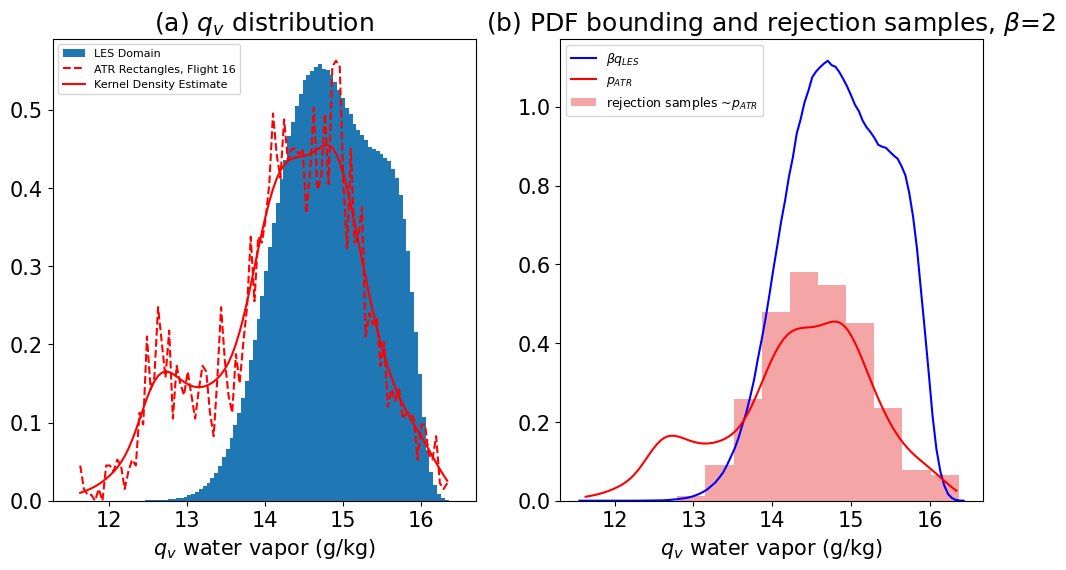

In [66]:
## comapre PDF of LES domain vs. ATR values
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(var_domain.values.flatten(), density=True, bins = 100, label='LES Domain')
ax1.plot(bin_centers_ATR, n_ATR, 'r--', label = 'ATR Rectangles, Flight 16')
ax1.plot(bin_centers_ATR, n_kde_ATR, label='Kernel Density Estimate', color='r')
# plt.plot(bin_centers, n, 'r--', label = 'ATR Rectangles, Flight 16')

ax1.set_title(f'(a) $q_v$ distribution')
ax1.legend(fontsize='8')
ax1.set_xlabel(f'$q_v$ water vapor (g/kg)')

ax2.plot(bin_centers, beta*n, label=f'$\\beta q_{{LES}}$', color='b')
ax2.plot(bin_centers_ATR, n_kde_ATR, label=f'$p_{{ATR}}$', color='r')
ax2.hist(x_samples[accepted_samples], density=True, bins=10, label=f"rejection samples ~$p_{{ATR}}$", color='lightcoral',alpha=0.7)
ax2.legend(fontsize='9')
ax2.set_xlabel(f'$q_v$ water vapor (g/kg)')
ax2.set_title(f'(b) PDF bounding and rejection samples, $\\beta$={beta}')

plt.savefig(f'generated_images/Fig_3_rejection_sample.png')

# Generate schematic figure

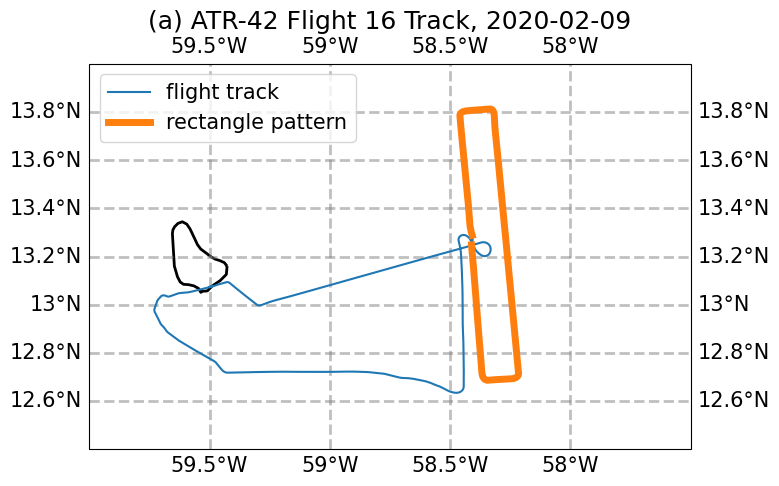

<Figure size 1000x500 with 0 Axes>

In [67]:
# generate map
fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw={
     'projection': ccrs.PlateCarree()})
#f = plt.figure(figsize=(50,25))
f = plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 15})



# Set map extent, coastline
ax.set_extent([-60, -57.5, 12.4, 14], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2, zorder=2)

# ATR
ax.plot(x, y, transform=ccrs.PlateCarree(), c = 'tab:blue', label='flight track', zorder=3)
ax.plot(x.sel(time=slice(p['start'], p['end'])), y.sel(time=slice(p['start'], p['end'])), transform=ccrs.PlateCarree(), c = 'tab:orange',linewidth=5, label='rectangle pattern', zorder=4)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_title('(a) ATR-42 Flight 16 Track, 2020-02-09')

f.tight_layout(pad=1.5)
ax.legend()

plt.show()

fig.savefig(f'generated_images/Fig_1A_ATR_track.png')

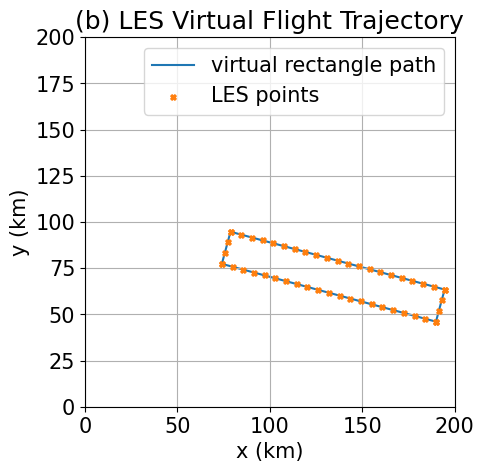

In [68]:
# plot virtual points
x_corners, y_corners, x_vtraj, y_vtraj, t_vtraj, var_vtraj = generate_virtual_flight(ds, var_name='TABS')

plt.plot(x_corners/1000,y_corners/1000, zorder=1, label='virtual rectangle path')
plt.scatter(x_vtraj/1000,y_vtraj/1000, s=15, c='tab:orange', marker='X', zorder=2, label='LES points')

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.legend()
plt.grid()
plt.title('(b) LES Virtual Flight Trajectory')

#plt.savefig(f'generated_images/virtual_flight_map_poster.png')
plt.savefig(f'generated_images/Fig_1B_LES_track.png')